# UFO

<font color='#660066'>
   
### Table of Contents

- [Data](#Data)
    - [Scraping from UFORC](#Scraping-from-UFORC)
    - [Data Format](#data_format)
    - [Cleaing Data](#cleaning_pdata)
- [Basic anlayis](#Basic-Anylsis)
- [Milestone 3](#milestones)

In [145]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import json
import pandas as pd
from lib.scraping import fetch_shape_urls,  \
                     fetch_all_sighting_urls, \
                     store_to_json, \
                     build_report_dataframe
from lib.postprocessing import get_time_of_occurrence, \
                           to_datetime_add_year, \
                           replace_empty_with_nan, \
                           distribution_histogram 
from lib.cleaning import post_process, \
                         split_nuforc_notes_from_summary, \
                         sightings_per_state_unnormalized
from lib.nuforc_analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
data_folder = "data/"

file_url_list = data_folder+'full_list_of_urls.json'

report_file = 'all_sightings_10k_sample.json'

<font color='#660066'>
   
# Data

## Scraping from UFORC

The National UFO Reporting Center (**NUFORC**) lists reports splitted by the occured date, by posting date, by shape or by location. These sightings has been collected since 1974. NUFORC provides a [Hotline](http://www.nuforc.org/Report.html) or [web formular]() to submit the UFO encounters. These reports are checked for hoax and fake reporst, according to [several reports](https://www.reddit.com/r/UFOs/comments/6h5jfc/nuforc_filters_their_reports_much_better_than/). The sightings also include articles from news papers and historical accounts.

We decided to scrape the data from their web page using the *request* and *beatifulsoup* libraries. 

The first step to fetch all the possible shapes and then we can fetch all the urls from each of the shape. 



In [19]:
all_shapes = fetch_shape_urls()
all_reporting_urls = fetch_all_sighting_urls(all_shapes)

Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kiru/anaconda3/envs/ada/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/kiru/anaconda3/envs/ada/lib/python3.6/site-packages/urllib3/connectionpool.py", line 377, in _make_request
    httplib_response = conn.getresponse(buffering=True)
  File "/Users/kiru/anaconda3/envs/ada/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/kiru/anaconda3/envs/ada/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/kiru/anaconda3/envs/ada/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/kiru/anaconda3/envs/ada/lib/python3.6/multiprocessing/pr

  File "/Users/kiru/anaconda3/envs/ada/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()
  File "/Users/kiru/anaconda3/envs/ada/lib/python3.6/http/client.py", line 297, in begin
    version, status, reason = self._read_status()
  File "/Users/kiru/anaconda3/envs/ada/lib/python3.6/http/client.py", line 258, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/kiru/anaconda3/envs/ada/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

<font color='#660066'>

Let's see how many shapes and reportings there are: 

In [ ]:
print("Number of shapes:", len(all_shapes))
print("Nubmer of sighting:", len(all_reporting_urls))

<font color='#660066'>

We don't want to constantly send requests to the server, therefore store the file in urls in a json file. 

In [ ]:
store_to_json(all_reporting_urls, file_url_list)

In [ ]:
# import href list of each report
with open(file_url_list) as train_file:
    href_data = json.load(train_file)
urls_to_read = href_data['url']['0']

<font color='#660066'>

Now we are ready to fetch all the reports and convert it to a Pandas Dataframe.

In [ ]:
%%time
df_reports = build_report_dataframe(urls_to_read)

In [ ]:
df_reports.to_json(data_folder + "all_sightings.json")

<font color='#660066'>

The whole scraping process took more than 1 hour. 

<font color='#660066'>
    
## Loading data

of course we dont want so scrape every time

In [20]:
df_reports = pd.read_json(data_folder + "all_sightings.json")
#df_reports.sample(2000).to_json("jurgis_2k.json")

In [ ]:
df_reports.sample(10_000).to_csv("jurgis_10k.csv")

In [ ]:
10_0000

<font color='#660066'>
   
The data contains the following columns: 

- Occurred
- Reported
- Posted
- Location
- Shape
- Duration
- Summary

The following sections analyze these data throughly. 

<font color='#660066'>
    
## Cleaning data

Let's see how many are not fetched:

In [21]:
not_found_reports = df_reports[pd.isnull(df_reports.Summary)]
print("Not fou£nd reports", not_found_reports.count()['url'])

Not fou£nd reports 105


<font color='#660066'>

These are reports which were not fetched correctly, we have to investigate further why these are missing. 

In [22]:
df_every_thing = df_reports.rename(index=str, columns={'Occurred ':'Occurred'})

<font color='#660066'>

In our dataset we noticed there are several emtpy strings. <br/>
We decided exchange these empty strings with NaN for easier parsing. 

In [23]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Occurred')

Occurred feature has 156 missing values


<font color='#660066'>

The function below does raw post processing on the scraped data such as cleaning whitespace, renaming the columns, ordering the columns and applies filters so that we only retrieve the desired data wich contains summary data and sufficient information for the states.


In [24]:
df_ufo_reports = post_process(df_reports)

splitting Location..


/Users/kiru/Documents/development/school/epfl/Semester_3/CS-401 Applied Data Analysis (ADA)/ada_project/lib/cleaning.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_ufo_reports['Location'] = df_splitted_locaiton.str[0]
/Users/kiru/Documents/development/school/epfl/Semester_3/CS-401 Applied Data Analysis (ADA)/ada_project/lib/cleaning.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_ufo_reports['State'] = df_splitted_locaiton.str[1]


cleaning Location..
cleaning State..


/Users/kiru/Documents/development/school/epfl/Semester_3/CS-401 Applied Data Analysis (ADA)/ada_project/lib/cleaning.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_ufo_reports['Location'] = df_ufo_reports['Location'].apply(lambda x: x.strip())


cleaning Reported
cleaning Posted..
re-ordering columns..
done


<font color='#660066'>

Spliting all nuforc notes of each summary into a seperate column.


In [25]:
df_ufo_reports = split_nuforc_notes_from_summary(df_ufo_reports)

In [26]:
df_ufo_reports[["Summary","nuforc_note"]].sample(5)

,Summary,nuforc_note
16660,"['Unexplained red and white light, like a star...",[]
17722,"['MYSTERIOUS ORANGE SPHERE', ""I was out walkin...",[]
103355,['Black triangle flying low over northwestern ...,[]
100917,['Diamond craft looks like a very large bright...,[]
40444,"['Orange Fireball Discs', 'This occurred at ab...",[]


<font color='#660066'>

### Occurred / Reported / Posted

In [27]:
converted = get_time_of_occurrence(df_every_thing)

/Users/kiru/Documents/development/school/epfl/Semester_3/CS-401 Applied Data Analysis (ADA)/ada_project/lib/postprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_time_occur_report.year[i] = df_time_occur_report.Occurred[i].year


<font color='#660066'>
Fro the plot above, we use a subsample of 1000 elements. 

To check the distribution of the occurance, wea are plotting the year at which the occurance has been noticed. <br />
The first occurance time is noted as 1400 AD, as a reference to a painting with a descriptive drawing of a plausible UFO.

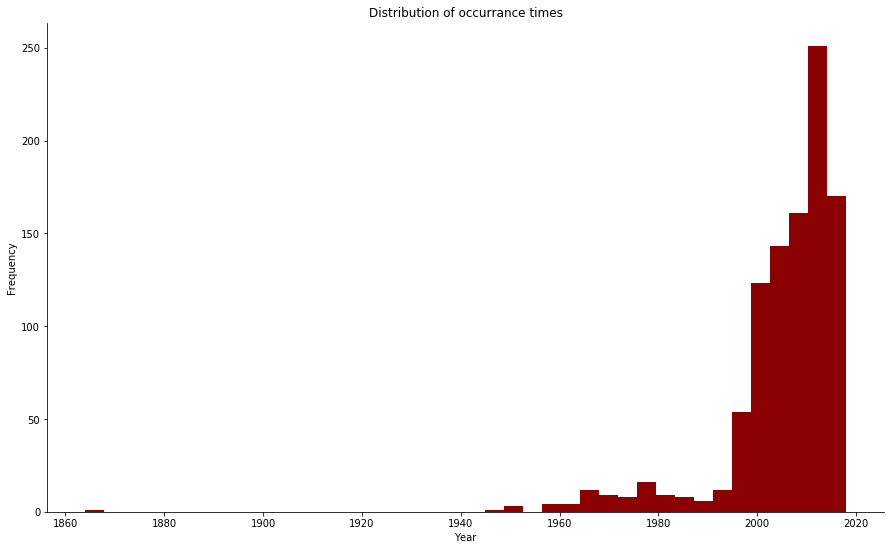

In [28]:
distribution_histogram(converted, 'year')

<font color='#660066'>
    
### Location

<font color='#660066'>

As most of the reportings are from the US, we are showing the distribution of reports from the different states. <br />
The data is not normalized at the moment.

In [29]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Location')

Location feature has 106 missing values


In [30]:
sightings_per_state_unnormalized(df_ufo_reports)

<font color='#660066'>

### Shape

<font color='#660066'>

The shapes feature consist of 31 different shapes, with the most populated being a 'light source'.

In [31]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Shape')

Shape feature has 3894 missing values


<font color='#660066'>
    
### Duration

<font color='#660066'>

The duration is a user created data format, with lots of different formats, thus the cleaning and parsing of this data will take a large effort.

In [32]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Duration')

Duration feature has 4121 missing values


<font color='#660066'>

### Summary

<font color='#660066'>

User made input as the summary about the witnessed UFO sighting of varying length. 

In [33]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Shape')

Shape feature has 3894 missing values


<font color='#660066'>
   

## Milestone 3

- Analyze words, keywords. 
- Read into sentiment analysis, to see if we can apply it to our case.
- Clean duration column
- Analyze if the people were at the time of the sighting
- Split NUFORC nodes
- Check for NUFORC generated HOAX messages
- Check out dem videos
- Keywords for sleep, dropping the reports which might have been dreams/sleep paralysis induced visions.
- Time of occurance/duration correlation
- Weather data (historic weather data, cloudy, sunny, storm, etc), general trends in US states (months with higher percipitation), sort the data by month and see which months have a higher rate of sightings (look in the years where there are the most sightings)
- Filter out MADAR data, see how much our dataset changes
- Analyze what shapes are associated with what feelings? 
- Analyze what shapes are consistently reported at same locations?

- Sentiment Analysis for summary text
    - start with vizualization of text
    ([inspiration](https://www.jasondavies.com/wordtree/?source=obama.inauguration.2013.txt&prefix=we%20must%20act))
- Correlation of weather and reports
- Analyze madar sensor data (also in correlation with weather)
- Create report results plots (webpage)


<font color='#660066'>

## NUFORC Note Analyse

Distribution of NUFORC notes

In [34]:
dist = get_noforc_note_count_distribution(df_ufo_reports)
dist

0    78790
1    36101
2     2348
3       69
4        2
Name: nuforc_note, dtype: int64

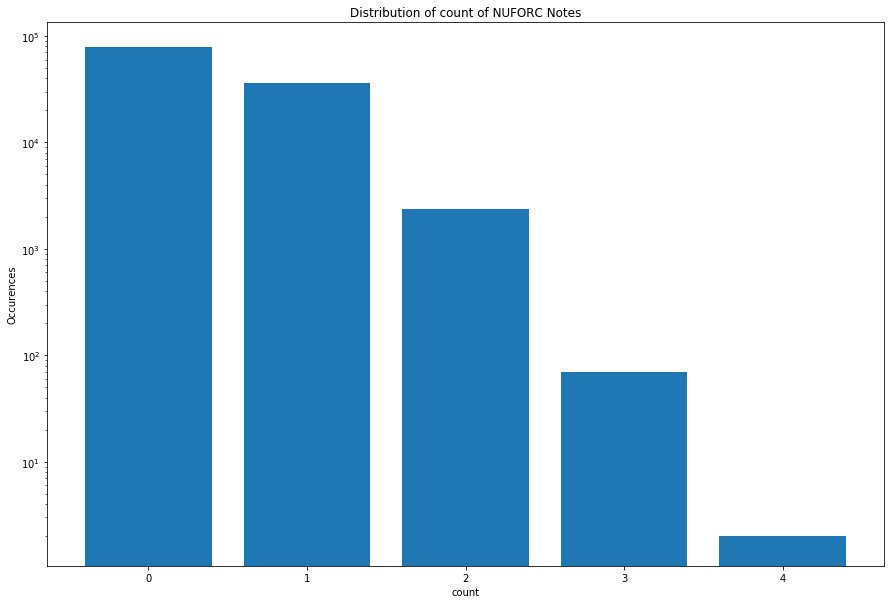

In [35]:
plot_distribution_of_notes(df_ufo_reports)


<font color='#660066'>

Filter all reports having n NUFORC Notes

In [3]:
df_notes = get_reports_having_n_notes(df_ufo_reports, 3)

NameError: name 'get_reports_having_n_notes' is not defined

In [2]:
df_notes.head()

NameError: name 'df_notes' is not defined

In [49]:
all_summaries = df_notes['Summary'].values

Analyze words, keywords.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [54]:


text = str(all_summaries)
x, y = np.ogrid[:1000, :1000]

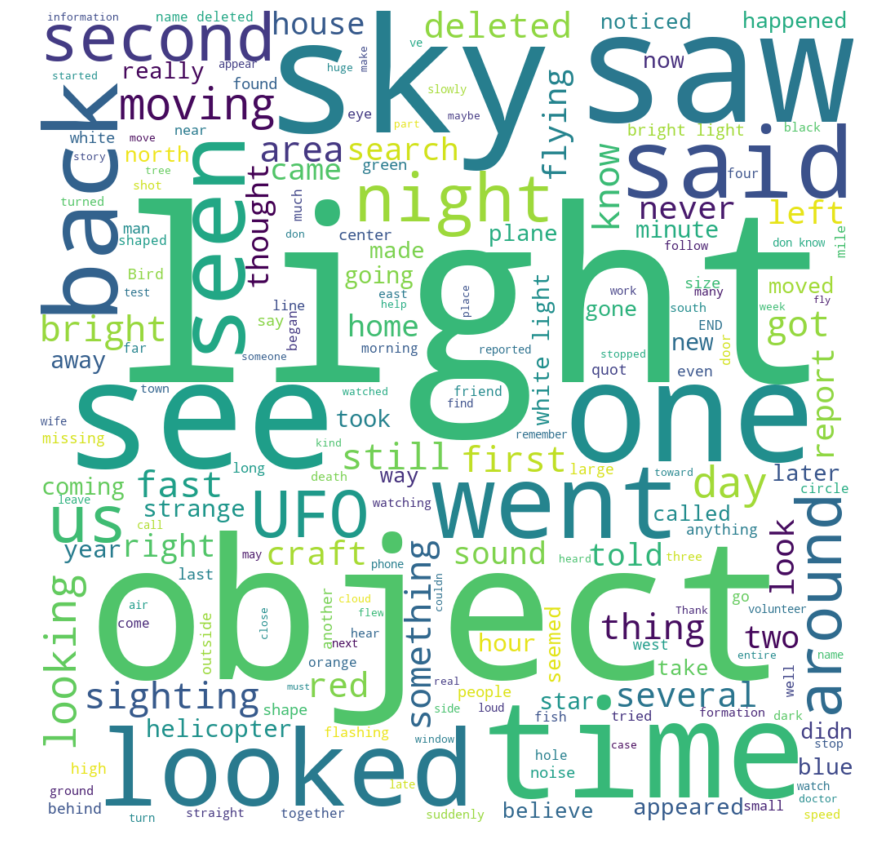

In [62]:
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)


wc = WordCloud(background_color="white", repeat=False, width=1000, height=1000)
wc.generate(text)
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [172]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to /Users/kiru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [185]:
wordToFrequency = {}
for item in all_summaries:
    tokens = tokenizer.tokenize(item)
    for t in tokens:
        if t.lower() not in stopwords.words('english'):
            #print(t.lower())
            if t in wordToFrequency:
                wordToFrequency.update({t: wordToFrequency[t] + 1})
            else:
                wordToFrequency[t] = 0

In [186]:
abc = pd.DataFrame.from_dict(wordToFrequency, orient='index')

In [187]:
abc.sort_values(0, ascending=False).head(100)

,0
like,86
light,83
sky,69
saw,65
lights,60
object,58
one,47
would,41
see,40
seen,39


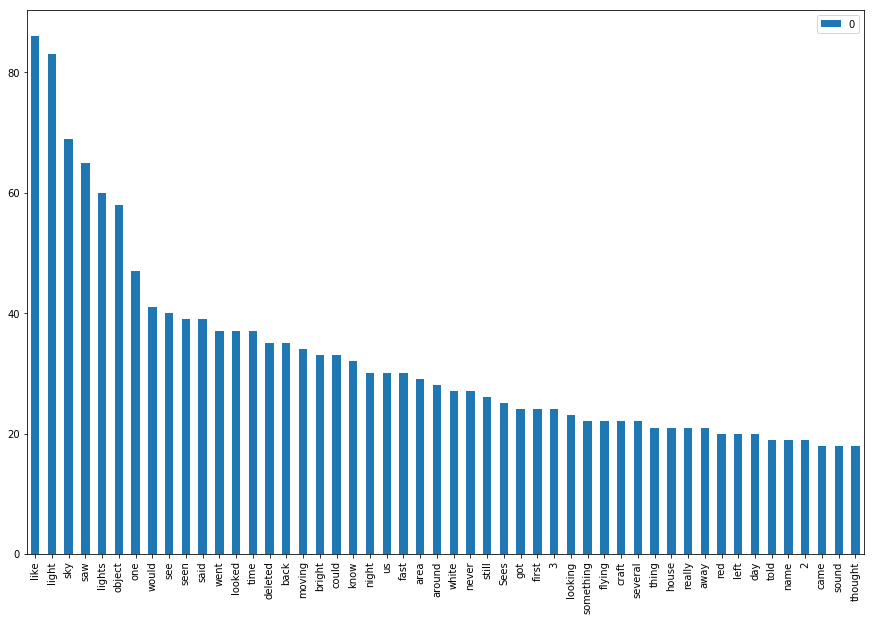

In [188]:
abc.sort_values(0, ascending=False).head(50).plot.bar(figsize=(15, 10))

In [197]:
a = pd.DataFrame.from_dict(dict(x = '2--3'), orient='index')

In [199]:
a[0].str.replace('-', '')

x    23
Name: 0, dtype: object

In [200]:
abc.head()

,0
World,0
Nuclear,0
Missiles,0
Must,0
Stop,0


In [222]:
df_one = df_reports.dropna(subset=['Summary'])
df_one[df_one.Summary.str.contains("youtube")].Summary.values

array(["['3 brilliant bright orb  lights observed in the Southwest desert, parked on a plateau in the middle of nowhere.', 'I want to  report that I saw  3 brilliant bright orbs of light at about 9:30 am on September 1, 2014.', '1.\\t  I was on a United Airlines flight from Denver to Orange County.  These bright blinding lights were flickering out in the middle of nowhere in the Southwest desert.  I believe the location was somewhere between the Grand Canyon and Nevada. It was in an area minus of any trees, rivers, or lakes. Only miles and miles of dry, arid brown and red soil in all directions  which looked as it had once been the bottom bed of a deep ocean.', 'The sky was clear on the morning of Sept. 1, 2014 and I saw three blinding bright lights flickering from a plateau.  These lights remained grounded in a stationary position on this plateau which was in an uninhabitable arid area with no sign of life for at least a hundred miles in any direction.   I saw no river or lake, on sig